In [87]:
import torch
import torchvision
import json
import jieba
import time
import numpy as np
from torch import nn, optim
from numpy import math
from gensim.models import word2vec as word
from torchtext import data as Data
from torchtext.vocab import Vectors
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = 'E:\Jason\Documents\深度学习\实验五\dataset'
stopwords = [line.strip() for line in open('stopword.txt', 'r', encoding='utf-8').readlines()]

lr = 1e-3
batch_size = 64
sentence_len = 50
embedding_size = 200
num_classes = 6
num_epochs = 50

## 1 词向量训练

In [2]:
# 读取数据
with open(data_dir+'/virus_train.txt','r', encoding='utf-8') as load_file:
    load_file = json.load(load_file)
    train_valid_split = 6606
    load_train = load_file[:train_valid_split]
    load_valid = load_file[train_valid_split:]
    print('train: %d, valid: %d' % (len(load_train), len(load_valid)))
with open(data_dir+'/virus_eval_labeled.txt', 'r', encoding='utf-8') as load_file:
    load_test = json.load(load_file)
    print('test: %d' % (len(load_test)))
load_file.close()

train: 6606, valid: 2000
test: 2000


In [3]:
# 分词(运行一次即可，保存至本地)
# stopwords = [line.strip() for line in open('stopword.txt', 'r', encoding='utf-8').readlines()]
# for sentence in load_train:
#     word_cut = jieba.cut(sentence['content'])
#     for words in word_cut:
#         if words not in stopwords:
#             if words != '\t':
#                 with open('word_cut.txt', 'a', errors='ignore', encoding='utf-8') as save_file:
#                     save_file.write(words+" ")
# save_file.close()

# for sentence in load_train:
#     word_cut = jieba.cut(sentence['content'])
#     with open('word_cut_nonestop.txt', 'a', errors='ignore', encoding='utf-8') as save_file:
#         save_file.write(" ".join(word_cut))
# save_file.close()

In [4]:
# 训练词向量
sentences = word.LineSentence('word_cut.txt')
model = word.Word2Vec(sentences, hs=1, min_count=1, window=3, size=100)
# print(len(model.wv.vocab))
# model.wv.vocab

## 2 数据预处理

In [5]:
# li = []
# suma = 0
# n = 0
# for f in load_train:
#     li.append(len(f['content']))
#     suma += len(f['content'])
#     n += 1
# la = sorted(li)
# print('max: %d, mean: %.4f' % (la[-1], suma/n))

# plt.plot(range(n), li)

In [9]:
# 分词，并去除停用词
def words_after_jieba(X):
    sentence = jieba.cut(X)
    words = []
    for word in sentence:
        if word not in stopwords:
            if word != '\t':
                words.append(word)
    return words

# 转换标签
def trans_labels(y):
    label_dict = {'neural':0, 'happy':1, 'angry':2, 'sad':3, 'fear':4, 'surprise':5}
    return label_dict[y]

In [54]:
# 构造数据集
TEXT = data.Field(fix_length=sentence_len, batch_first=True)
LABEL = data.LabelField(dtype=torch.float)

def get_dataset(load_data, text_field, label_field):
    fields = [('text', text_field), ('label', label_field)]
    examples = []

    for data in load_data:
        content = words_after_jieba(data['content'])
        label = trans_labels(data['label'])
        examples.append(Data.Example.fromlist([content, label], fields))

    return examples, fields

train_examples, train_fields = get_dataset(load_train, TEXT, LABEL)
valid_examples, valid_fields = get_dataset(load_valid, TEXT, LABEL)
test_examples, test_fields = get_dataset(load_test, TEXT, LABEL)

train_set = Data.Dataset(train_examples, train_fields)
valid_set = Data.Dataset(valid_examples, valid_fields)
test_set = Data.Dataset(test_examples, test_fields)

# Todo...
TEXT.build_vocab(train_set)
LABEL.build_vocab(train_set)

train_iter = Data.BucketIterator(train_set, batch_size, sort=False, device=device)
valid_iter = Data.BucketIterator(valid_set, batch_size, sort=False, device=device)
test_iter = Data.BucketIterator(test_set, batch_size, sort=False, device=device)

# print(next(iter(train_iter)).text.shape)     
# print(next(iter(train_iter)).label.shape)

## 3 构建TextCNN网络

In [58]:
# 定义模型
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_size,
                 filter_num=100, kernel_list=(3,4,5), dropout=0.5):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Sequential(
                nn.Conv2d(1, filter_num, (kernel, embedding_dim)),
                nn.ReLU(),
                nn.MaxPool2d((sentence_len-kernel+1, 1))
            ) for kernel in kernel_list]
        )
        self.fc = nn.Linear(filter_num * len(kernel_list), output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x) # (batch_size, word_num, embedding_dim)
        x = x.unsqueeze(1) # (batch_size, channel_num, word_num, embedding_dim)
        out = [conv(x) for conv in self.convs]
        out = torch.cat(out, dim=1) # (batch_size, )
        out = out.view(x.size(0), -1) # (batch_size)
        out = self.dropout(out)
        out = self.fc(out) # (batch_size, )
        return out

In [59]:
# 计算准确率函数
def binary_acc(preds, y):
     correct = torch.eq(preds, y).float()
     acc = correct.sum() / len(correct)
     return acc    

In [80]:
# 训练函数
def train_epoch(net, iterator, optimizer, criterion):
    avg_acc = []
    net.train()

    for i, batch in enumerate(iterator):
        pred = net(batch.text)
        loss = criterion(pred, batch.label.long())

        acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)
        avg_acc.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_acc = torch.mean(torch.stack(avg_acc))
    return avg_acc

In [81]:
# 测试函数
def test_epoch(net, iterator, criterion):
    avg_acc = []
    net.eval()

    with torch.no_grad():
        pred = net(batch.text)
        acc = binary_acc(torch.max(pred, dim=1)[1], batch.label)
        avg_acc.append(acc)

    avg_acc = torch.mean(torch.stack(avg_acc))
    return avg_acc

In [90]:
# 使用模型
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

net = TextCNN(len(TEXT.vocab), embedding_size, num_classes).to(device)
# pretrained_embedding = TEXT.vocab.vectors
# net.embedding.weight.data.copy_(pretrained_embedding)
net.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_size)
net.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_size)

optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_acc_list, valid_acc_list = [], []
for epoch in range(num_epochs):
    train_acc = train_epoch(net, train_iter, optimizer, criterion)
    valid_acc = test_epoch(net, valid_iter, criterion)
    print("epoch {}, train acc={}, valid acc={}".format(epoch+1, train_acc, valid_acc))

    train_acc_list.append(train_acc)
    valid_acc_list.append(valid_acc)

epoch=1, train acc=0.5798634886741638, valid acc=0.515625
epoch=2, train acc=0.6959564089775085, valid acc=0.453125
epoch=3, train acc=0.7682864665985107, valid acc=0.46875
epoch=4, train acc=0.8225446939468384, valid acc=0.515625
epoch=5, train acc=0.8623583912849426, valid acc=0.484375
epoch=6, train acc=0.8902387022972107, valid acc=0.5
epoch=7, train acc=0.9069797992706299, valid acc=0.515625
epoch=8, train acc=0.9182692766189575, valid acc=0.53125
epoch=9, train acc=0.9248584508895874, valid acc=0.5
epoch=10, train acc=0.9371137022972107, valid acc=0.53125
epoch=11, train acc=0.9395175576210022, valid acc=0.515625
epoch=12, train acc=0.9450764656066895, valid acc=0.546875
epoch=13, train acc=0.9502704739570618, valid acc=0.53125
epoch=14, train acc=0.9534898996353149, valid acc=0.546875
epoch=15, train acc=0.959199070930481, valid acc=0.484375
epoch=16, train acc=0.9552069902420044, valid acc=0.515625
epoch=17, train acc=0.9601863622665405, valid acc=0.5625
epoch=18, train acc=0.9

## 4 绘制图像

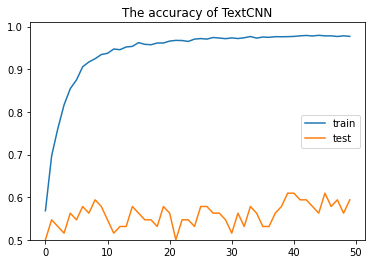

In [89]:
plt.plot(train_acc_list)
plt.plot(valid_acc_list)
plt.ylim(ymin=0.5, ymax=1.01)
plt.title("The accuracy of TextCNN")
plt.legend(["train", "test"])